# 32. Orquestração Multi-Agente com LangGraph: Caso Companhia Aérea

## Objetivo
Criar um fluxo de trabalho com **3 Agentes** autônomos para montar um pacote de viagem:
1.  **Agente Pesquisador**: Busca voos da TAM (Simulado).
2.  **Agente de Marketing**: Cria uma campanha publicitária para o pacote usando **LLM (OpenAI)**.
3.  **Agente de Precificação**: Calcula custos e define o preço final com margem de lucro de 10%.

**Stack Tecnológica:**
- **LangGraph**: Para orquestrar o fluxo (Grafo de Estados).
- **Pydantic**: Para validação rigorosa de dados e definição do Estado.
- **LangChain**: Para estruturar os agentes e ferramentas.
- **OpenAI (GPT-4o)**: Para geração criativa.

In [1]:
%%capture
!pip install -q langgraph langchain langchain-openai pydantic python-dotenv

In [2]:
import random
import os
from dotenv import load_dotenv
from typing import List, Optional
from typing_extensions import TypedDict  # Importante para LangGraph
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END

# Carrega variáveis de ambiente (API Keys)
_ = load_dotenv()

## 1. Definindo os Modelos de Dados (Pydantic)
Estruturamos os dados que trafegarão entre os agentes.

In [3]:
class Voo(BaseModel):
    companhia: str
    numero_voo: str
    origem: str
    destino: str
    horario_saida: str
    custo_operacional: float

class CampanhaMarketing(BaseModel):
    slogan: str = Field(description="Slogan criativo e curto para a campanha")
    descricao_visual: str = Field(description="Descrição detalhada da imagem promocional")
    publico_alvo: str = Field(description="Público alvo principal da campanha")
    custo_marketing: float = Field(description="Custo estimado da campanha")

class PacoteFinal(BaseModel):
    voo: Voo
    campanha: CampanhaMarketing
    custo_total: float
    margem_lucro: float
    preco_venda: float

## 2. Definindo o Estado do Grafo
O `AgentState` é o objeto compartilhado que todos os 'nós' (agentes) podem ler e escrever.

In [4]:
class AgentState(TypedDict):
    # Inputs iniciais
    origem: str
    destino: str
    data_desejada: str
    
    # Dados gerados pelos agentes
    opcoes_voos: Optional[List[Voo]]
    voo_selecionado: Optional[Voo]
    campanha: Optional[CampanhaMarketing]
    pacote_final: Optional[PacoteFinal]
    
    # Histórico de mensagens (opcional, para debug)
    messages: List[BaseMessage]

## 3. Criando os Agentes (Nodes)

### Agente 1: Pesquisador de Voos (TAM)
Simula uma busca na API da TAM.

In [5]:
def agente_pesquisador_voos(state: AgentState):
    print("\n--- [Agente Pesquisador] Buscando voos da TAM ---")
    origem = state['origem']
    destino = state['destino']
    
    # Simulação de dados (Mock)
    voos_encontrados = [
        Voo(
            companhia="TAM", 
            numero_voo=f"JJ{random.randint(1000, 9999)}",
            origem=origem,
            destino=destino,
            horario_saida="08:00",
            custo_operacional=random.uniform(800, 1200)
        ),
        Voo(
            companhia="TAM", 
            numero_voo=f"JJ{random.randint(1000, 9999)}",
            origem=origem,
            destino=destino,
            horario_saida="20:00",
            custo_operacional=random.uniform(750, 1100)
        )
    ]
    
    # Seleciona o mais barato automaticamente para simplificar
    voo_selecionado = min(voos_encontrados, key=lambda x: x.custo_operacional)
    
    print(f"Voo selecionado: {voo_selecionado.numero_voo} (Custo: R$ {voo_selecionado.custo_operacional:.2f})")
    
    return {
        "opcoes_voos": voos_encontrados,
        "voo_selecionado": voo_selecionado
    }

### Agente 2: Marketing (Powered by LLM)
Cria o conceito da campanha usando OpenAI.

In [6]:
def agente_marketing(state: AgentState):
    print("\n--- [Agente Marketing] Criando campanha com LLM ---")
    destino = state['destino']
    voo = state['voo_selecionado']
    
    # Instanciando o LLM com Saída Estruturada (Pydantic)
    # Certifique-se de que OPENAI_API_KEY está no .env
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
    
    # Definindo o prompt
    prompt_template = ChatPromptTemplate.from_messages([
        ("system", "Você é um publicitário criativo de uma companhia aérea experiente."),
        ("user", "Crie uma campanha de marketing para uma viagem com destino a {destino} voando pela {companhia}. O público alvo são {publico}. O custo de marketing deve ser fixo em 150.00.")
    ])
    
    # Forçando a saída estruturada
    structured_llm = llm.with_structured_output(CampanhaMarketing)
    
    # Executando
    chain = prompt_template | structured_llm
    
    campanha = chain.invoke({
        "destino": destino, 
        "companhia": voo.companhia,
        "publico": "jovens aventureiros e famílias"
    })
    
    # Garantindo que o custo seja o esperado (caso o LLM alucine valor diferente)
    campanha.custo_marketing = 150.00
    
    print(f"Slogan Gerado: {campanha.slogan}")
    print(f"Visual: {campanha.descricao_visual}")
    
    return {"campanha": campanha}

### Agente 3: Precificação
Consolida custos e aplica margem.

In [7]:
def agente_precificacao(state: AgentState):
    print("\n--- [Agente Precificação] Calculando custos e margens ---")
    voo = state['voo_selecionado']
    campanha = state['campanha']
    
    custo_total = voo.custo_operacional + campanha.custo_marketing
    margem_percentual = 0.10  # 10%
    lucro = custo_total * margem_percentual
    preco_final = custo_total + lucro
    
    pacote = PacoteFinal(
        voo=voo,
        campanha=campanha,
        custo_total=custo_total,
        margem_lucro=lucro,
        preco_venda=preco_final
    )
    
    print(f"Custo Total: R$ {custo_total:.2f}")
    print(f"Lucro (10%): R$ {lucro:.2f}")
    print(f"PREÇO FINAL: R$ {preco_final:.2f}")
    
    return {"pacote_final": pacote}

## 4. Construindo o Grafo (Workflow)
Aqui definimos a ordem de execução:
`Início` -> `Pesquisador` -> `Marketing` -> `Precificação` -> `Fim`

In [8]:
workflow = StateGraph(AgentState)

# Adicionando os nós
workflow.add_node("Pesquisador", agente_pesquisador_voos)
workflow.add_node("Marketing", agente_marketing)
workflow.add_node("Precificacao", agente_precificacao)

# Definindo as arestas (fluxo)
workflow.set_entry_point("Pesquisador")
workflow.add_edge("Pesquisador", "Marketing")
workflow.add_edge("Marketing", "Precificacao")
workflow.add_edge("Precificacao", END)

# Compilando o grafo
app = workflow.compile()

## 5. Executando a Simulação

In [9]:
# Dados de entrada
inputs = {
    "origem": "São Paulo (GRU)",
    "destino": "Paris (CDG)",
    "data_desejada": "2023-12-25",
    "messages": []
}

# Executando o fluxo
resultado = app.invoke(inputs)

# Exibindo o Resultado Final Estruturado
print("\n================ RELATÓRIO FINAL ================")
pacote = resultado['pacote_final']
print(f"DESTINO: {pacote.voo.destino}")
print(f"VOO: {pacote.voo.companhia} {pacote.voo.numero_voo} | Saída: {pacote.voo.horario_saida}")
print(f"CAMPANHA: \"{pacote.campanha.slogan}\"")
print(f"Preço ao Consumidor: R$ {pacote.preco_venda:.2f}")


--- [Agente Pesquisador] Buscando voos da TAM ---
Voo selecionado: JJ4494 (Custo: R$ 931.37)

--- [Agente Marketing] Criando campanha com LLM ---


Slogan Gerado: Voe Alto, Explore Paris!
Visual: Um cartaz vibrante mostrando a Torre Eiffel ao fundo, com jovens e uma família sorrindo e se divertindo em um piquenique no Champ de Mars. Balões coloridos flutuam no ar, e um avião da TAM voa ao longe. O texto inclui 'Descubra Paris: A Cidade das Luzes te espera!' em letras grandes e chamativas, com detalhes de promoções para jovens e pacotes familiares na parte inferior.

--- [Agente Precificação] Calculando custos e margens ---
Custo Total: R$ 1081.37
Lucro (10%): R$ 108.14
PREÇO FINAL: R$ 1189.50

================ RELATÓRIO FINAL ================
DESTINO: Paris (CDG)
VOO: TAM JJ4494 | Saída: 20:00
CAMPANHA: "Voe Alto, Explore Paris!"
Preço ao Consumidor: R$ 1189.50


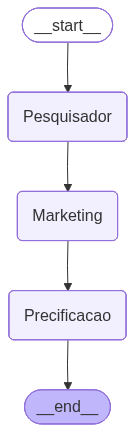

In [10]:
# Visualizando o Grafo (Opcional - requer graphviz)
try:
    from IPython.display import Image
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    print("Não foi possível gerar a imagem do grafo (biblioteca pode estar faltando), mas o fluxo executou corretamente.")